In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional, LSTM, Flatten, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

2024-03-21 15:09:41.786062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 15:09:41.786108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 15:09:41.788383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 15:09:41.797433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Importing the dataset
train = pd.read_csv('emotions_all.csv')

train # Display the first 5 rows of the train dataset

,sentence,emotion
0,That game hurt.,sadness
1,Man I love reddit.,happiness
2,Right? Considering it’s such an important docu...,happiness
3,"He isn't as big, but he's still quite popular....",disgust
4,That's crazy; I went to a super [RELIGION] hig...,happiness
...,...,...
522597,Ew just stepped on a mammoth size snail while ...,disgust
522598,the awkward moment when an 'ex' calls u 'sis' ...,disgust
522599,"“@BarackObama: Tonight, Senate Republicans vot...",disgust
522600,This bus smell like straight FISH !!,disgust


In [3]:
# Checking the amount of value each emotion has
train['emotion'].value_counts()

emotion
happiness    219780
sadness      134488
anger         72349
fear          52477
surprise      31060
disgust       12448
Name: count, dtype: int64

In [4]:
# Drop the first 200k happiness emotions in the emotion column
train = train.drop(train[train['emotion'] == 'happiness'].index[:100000])

# Reset the index
train = train.reset_index(drop=True)

# Display the first 5 rows
train.head()

,sentence,emotion
0,That game hurt.,sadness
1,"He isn't as big, but he's still quite popular....",disgust
2,"I wanted to downvote this, but it's not your f...",sadness
3,That is odd.,sadness
4,That is odd.,disgust


In [5]:
# Amount of emotions in emotion column
train['emotion'].value_counts()

emotion
sadness      134488
happiness    119780
anger         72349
fear          52477
surprise      31060
disgust       12448
Name: count, dtype: int64

In [6]:
# Loading in the test dataset
test = pd.read_csv('test.csv', sep='\t')

test.head() #Display the first 5 rows of the test dataset

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."


In [8]:
# Extracting the sentences and labels from the training and testing datasets.
train_sentences = train['sentence'].values
train_labels = train['emotion'].values
test_sentences = test['sentence'].values

In [9]:
# Preprocess labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded)

In [10]:
# Tokenize sentences
tokenizer = Tokenizer(oov_token='<OOV>', num_words=10000000)
tokenizer.fit_on_texts(train_sentences)
tokenizer.fit_on_texts(test_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [11]:
# Pad sequences for training data
max_length = max(len(x) for x in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

# Pad sequences for testing data using the same max_length
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [12]:
# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels_one_hot, test_size=0.2, random_state=42)

In [13]:
unique_emotions = train['emotion'].unique()
num_emotions = len(unique_emotions)
print("Unique emotions:", unique_emotions)
print("Number of unique emotions:", num_emotions)

Unique emotions: ['sadness' 'disgust' 'surprise' 'anger' 'fear' 'happiness']
Number of unique emotions: 6


In [14]:
# Define the parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 64  # Dimensionality of the embedding layer
num_emotions = len(unique_emotions)  # Number of unique emotions

# Defining the RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=400, input_length=235),  # Increased embedding dimension
    Bidirectional(LSTM(516, return_sequences=True)),  # Adjusted LSTM units
    # Dropout(0.5),  # Added dropout for regularization
    Dense(256, activation='relu'),
    GlobalMaxPool1D(),  # Global max pooling
    Dense(128, activation='relu'),  # Adjusted Dense layer units
    Dense(64, activation='relu'),
    # Dropout(0.5),  # Added dropout for regularization
    Dense(num_emotions, activation='softmax')  # Output layer
])

model.summary() # Display the model summary

2024-03-21 15:09:58.904289: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-21 15:09:58.904580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3200 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 235, 400)          31337600  
                                                                 
 bidirectional (Bidirection  (None, 235, 1032)         3785376   
 al)                                                             
                                                                 
 dense (Dense)               (None, 235, 256)          264448    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [15]:
def f1_score(y_true, y_pred):
    # Calculate Precision and Recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate F1 score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
# Compiling the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[f1_score])

In [17]:
# Training the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=128, 
                    validation_data=(X_val, y_val),
                    verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100


2024-03-21 15:10:02.728692: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-21 15:10:03.326932: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f39bc892430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 15:10:03.326965: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-21 15:10:03.332945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711033803.458391 2122445 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2642/2642 [==============================] - 193s 72ms/step - loss: 0.3770 - f1_score: 0.8469 - val_loss: 0.3071 - val_f1_score: 0.8782
Epoch 2/100
2642/2642 [==============================] - 155s 59ms/step - loss: 0.2870 - f1_score: 0.8824 - val_loss: 0.3006 - val_f1_score: 0.8793
Epoch 3/100
2642/2642 [==============================] - 154s 58ms/step - loss: 0.2601 - f1_score: 0.8902 - val_loss: 0.3119 - val_f1_score: 0.8782
Epoch 4/100
2642/2642 [==============================] - 153s 58ms/step - loss: 0.2364 - f1_score: 0.8968 - val_loss: 0.3384 - val_f1_score: 0.8745
Epoch 5/100
2642/2642 [==============================] - 153s 58ms/step - loss: 0.2147 - f1_score: 0.9027 - val_loss: 0.3738 - val_f1_score: 0.8692
Epoch 6/100
2642/2642 [==============================] - 152s 57ms/step - loss: 0.1972 - f1_score: 0.9074 - val_loss: 0.4618 - val_f1_score: 0.8637
Epoch 7/100
2642/2642 [==============================] - 152s 58ms/step - loss: 0.1831 - f1_score: 0.9111 - val_loss: 0.4995

In [19]:
y_pred = model.predict(X_val) # For confusion matrix
# y_pred = model.predict(test_padded) # For Kaggle submission

2642/2642 [==============================] - 30s 11ms/step


In [20]:
# Convert predictions to label indices
predicted_class_indices = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Use the LabelEncoder to decode the predictions to original labels
predicted_emotions = label_encoder.inverse_transform(predicted_class_indices)

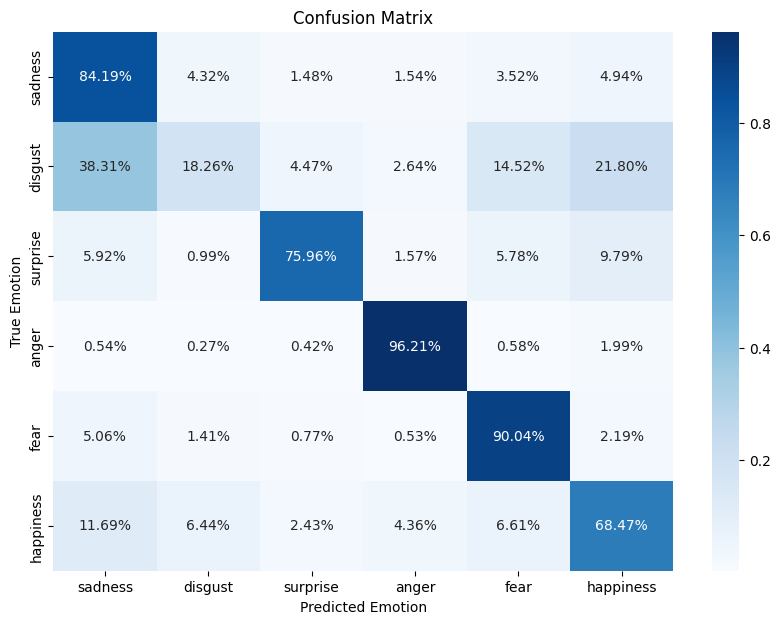

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_class_indices)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=unique_emotions, yticklabels=unique_emotions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()

In [52]:
# Add predictions to my test dataset
test['emotion'] = predicted_emotions

In [53]:
# Displaying the new test dataset
test.head()

,id,sentence,emotion
0,0,Girls are happy when they get flowers,happiness
1,1,His jaw dropped in disbelief when he saw the p...,surprise
2,2,Sometimes the ugly stench makes me wanna throw...,anger
3,3,The foul odor from the garbage bin was disgust...,disgust
4,4,"I can’t believe it, they lost the game in the ...",surprise


In [54]:
# Drop sentence column
test = test.drop(columns=['sentence'])

test.head()

,id,emotion
0,0,happiness
1,1,surprise
2,2,anger
3,3,disgust
4,4,surprise


In [55]:
test.to_csv('rnn_model_max_4_moredata.csv', index=False)